In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, clear_output
import time
import json

from itertools import product
from collections import namedtuple
from collections import OrderedDict

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.5.1
0.6.1


In [3]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [4]:
class Network(nn.Module): #line 1
    def __init__(self):
        super(Network,self).__init__() #line 3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self,t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t,kernel_size=2, stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t,kernel_size=2, stride=2)

        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)

        return t

In [5]:
train_set = torchvision.datasets.MNIST(
    root = './data/MNIST/',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

Extracting ./data/MNIST/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST/MNIST\raw


Extracting ./data/MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST\raw


Extracting ./data/MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST\raw


Extracting ./data/MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [6]:
batch_size=1000
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

In [7]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

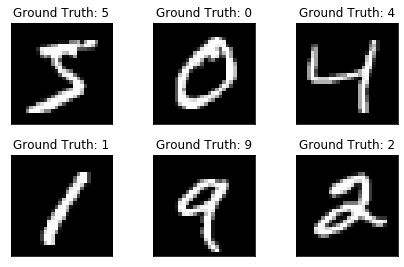

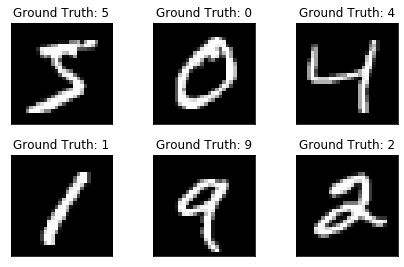

In [8]:
from matplotlib import pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [9]:
parameters = dict(
    lr = [.01]
    ,batch_size = [1000]
    ,shuffle = [True]
)
param_values = [v for v in parameters.values()]

In [10]:
for  lr,batch_size, shuffle in product(*param_values): 
    network = Network()
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    optimizer = optim.Adam(network.parameters(), lr=lr)
    
    images, labels = next(iter(train_loader))
    grid = torchvision.utils.make_grid(images)
    #comment=f' batch_size={batch_size} lr={lr} shuffle={shuffle}'
    '''
    tb = SummaryWriter(comment=comment)
    tb.add_image('images', grid)
    tb.add_graph(network, images)
    '''
    for epoch in range(5):
        total_loss = 0
        total_correct = 0
        for batch in train_loader:
            images, labels = batch # Get Batch
            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss
            optimizer.zero_grad() # Zero Gradients
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights

            total_loss += loss.item() * batch_size
            total_correct += get_num_correct(preds, labels)

        #zapisanie danych do wykresów
        '''
        tb.add_scalar('Loss', total_loss, epoch)
        tb.add_scalar('Number Correct', total_correct, epoch)
        tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)
        
        for name, param in network.named_parameters():
            tb.add_histogram(name, param, epoch)
            tb.add_histogram(f'{name}.grad', param.grad, epoch)
        '''
        print("epoch", epoch,"total_correct:", total_correct,"loss:", total_loss,"accuracy:",total_correct / len(train_set)) 

epoch 0 total_correct: 49278 loss: 33671.95016145706 accuracy: 0.8213
epoch 1 total_correct: 57947 loss: 6591.934517025948 accuracy: 0.9657833333333333
epoch 2 total_correct: 58682 loss: 4194.239784032106 accuracy: 0.9780333333333333
epoch 3 total_correct: 58934 loss: 3357.0208232849836 accuracy: 0.9822333333333333
epoch 4 total_correct: 59151 loss: 2737.3482678085566 accuracy: 0.98585


In [11]:
with torch.no_grad():
  output = network(example_data)

network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

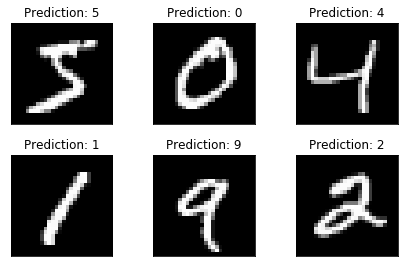

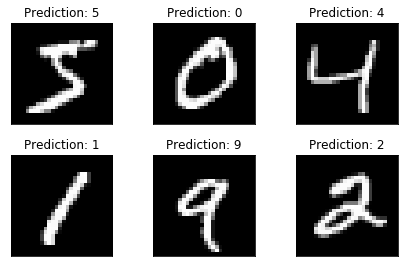

In [12]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [13]:
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(10) ]
output_names = [ "output1" ]

#torch.onnx.export(network, example_data, "mnist.onnx", verbose=True, input_names=input_names, output_names=output_names)
torch.onnx.export(network, example_data, "mnist.onnx", verbose=True)

graph(%input.1 : Float(1000, 1, 28, 28),
      %conv1.weight : Float(6, 1, 5, 5),
      %conv1.bias : Float(6),
      %conv2.weight : Float(12, 6, 5, 5),
      %conv2.bias : Float(12),
      %fc1.weight : Float(120, 192),
      %fc1.bias : Float(120),
      %fc2.weight : Float(60, 120),
      %fc2.bias : Float(60),
      %out.weight : Float(10, 60),
      %out.bias : Float(10)):
  %11 : Float(1000, 6, 24, 24) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1]](%input.1, %conv1.weight, %conv1.bias) # C:\Users\akozo\anaconda3\lib\site-packages\torch\nn\modules\conv.py:350:0
  %12 : Float(1000, 6, 24, 24) = onnx::Relu(%11) # C:\Users\akozo\anaconda3\lib\site-packages\torch\nn\functional.py:1063:0
  %13 : Float(1000, 6, 12, 12) = onnx::MaxPool[kernel_shape=[2, 2], pads=[0, 0, 0, 0], strides=[2, 2]](%12) # C:\Users\akozo\anaconda3\lib\site-packages\torch\nn\functional.py:539:0
  %14 : Float(1000, 12, 8, 8) = onnx::Conv[dilations=[1, 1], group=1, k

In [14]:
import onnx

# Load the ONNX model
model = onnx.load("mnist.onnx")

# Check that the IR is well formed
#onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %input.1[FLOAT, 1000x1x28x28]\n) initializers (\n  %conv1.bias[FLOAT, 6]\n  %conv1.weight[FLOAT, 6x1x5x5]\n  %conv2.bias[FLOAT, 12]\n  %conv2.weight[FLOAT, 12x6x5x5]\n  %fc1.bias[FLOAT, 120]\n  %fc1.weight[FLOAT, 120x192]\n  %fc2.bias[FLOAT, 60]\n  %fc2.weight[FLOAT, 60x120]\n  %out.bias[FLOAT, 10]\n  %out.weight[FLOAT, 10x60]\n) {\n  %11 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%input.1, %conv1.weight, %conv1.bias)\n  %12 = Relu(%11)\n  %13 = MaxPool[kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%12)\n  %14 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%13, %conv2.weight, %conv2.bias)\n  %15 = Relu(%14)\n  %16 = MaxPool[kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%15)\n  %17 = Constant[value = <Tensor>]()\n  %18 = Reshape(%16, %17)\n  %19 = Gemm[alpha = 1, beta = 1, transB = 1](%18, %fc1.weight, %fc1.bias)\n  %2

In [37]:
model.graph.initializer[0]

dims: 6
data_type: 1
name: "conv1.bias"
raw_data: "\325*\254:\322R\220\272W\254Y\274\017\337\005\275\tQ@>\236,\203="

In [38]:
model.graph.initializer[1]

dims: 6
dims: 1
dims: 5
dims: 5
data_type: 1
name: "conv1.weight"
raw_data: "\322G&\275\343c\242>\346\254\265=\240\307*=\261]\"\276\334\317\\\276\316)\253>\010\217h>\266\3131=\250\360\033\276\033h9\276[\322\364=\227\302\033>\204\022;>$\347\022\276\272\353\213\276\354XV;\211\265\005>\242/\307>\220r\033\275\314\312\275\275\227[\016\274\315\177U>\007\242\227>\331\216\225>CJ#>\220\376\204=\242\236\201\275\222\225\273=\220/(\276=n\223=\3443\226>\267\235\034\275{\025\001>\014\016\017>\242e?>\232)\233>2\340M=\t\373\034\275\360v7>\361\2250\276}\240\004=\371\370\360=\007tK\276@Z2>F\004:\276W\016\265\276\273\337\303=\250e\002\276+\233\367=J[\224>\340\277\205>\251\207f\275\006\230\254=\376\372l\274\'J!>\200\245\203>\277\0170\275`u\210\276+\317\274\275\367E\330>\217:\007>\215+\215\276\216\315\205\276)\t\026> \222\207>Y\240\311\275gm{\274\030Vx;\360\305/\276\252\217!>\032&\213\276,\224\214\276\030\363\226\276\220\236R\276}\331/>\364\271\001>\315\267\257=\024\277\320\275\202l\260\276\320\352w>e\261\

In [39]:
model.graph.initializer[2].dims

[12]

In [40]:
for net in model.graph.initializer:
    print("dimensions:",net.dims,"name:",net.name)

dimensions: [6] name: conv1.bias
dimensions: [6, 1, 5, 5] name: conv1.weight
dimensions: [12] name: conv2.bias
dimensions: [12, 6, 5, 5] name: conv2.weight
dimensions: [120] name: fc1.bias
dimensions: [120, 192] name: fc1.weight
dimensions: [60] name: fc2.bias
dimensions: [60, 120] name: fc2.weight
dimensions: [10] name: out.bias
dimensions: [10, 60] name: out.weight


In [64]:
i = 0
for net in model.graph.node:
    #print("No.",i," input:",net.input,"\nattribiute",net.attribute)
    
    try:
        print("No.",i," input:",net.input,"attribiute",len(net.attribute))
    except:
        print("No.",i," input:",net.input,"attribiute",len(net.attribute))
    i+=1

No. 0  input: ['input.1', 'conv1.weight', 'conv1.bias'] attribiute 5
No. 1  input: ['11'] attribiute 0
No. 2  input: ['12'] attribiute 3
No. 3  input: ['13', 'conv2.weight', 'conv2.bias'] attribiute 5
No. 4  input: ['14'] attribiute 0
No. 5  input: ['15'] attribiute 3
No. 6  input: [] attribiute 1
No. 7  input: ['16', '17'] attribiute 0
No. 8  input: ['18', 'fc1.weight', 'fc1.bias'] attribiute 3
No. 9  input: ['19'] attribiute 0
No. 10  input: ['20', 'fc2.weight', 'fc2.bias'] attribiute 3
No. 11  input: ['21'] attribiute 0
No. 12  input: ['22', 'out.weight', 'out.bias'] attribiute 3
